### Plotting notebook

### Import necessary packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import glob
import re
import io
import os
import sys 
sys.path.append('..')
from brian2 import *
import brian_utils.postproc as bup
import pickle
import random
from collections import OrderedDict
cmaps = OrderedDict()
#matplotlib.style.use('ggplot')

### Create line plot of instantaneous frequency, amplitude, or width throughout the simulation

In [2]:
# Example: line_plot(df, 'Burst Amp', '+')
def line_plot(df, response, g_nap_sign, run_seed):
    single_sim = df.loc[df['run_seed'] == run_seed]
    
    g_nap_01 = single_sim.loc[single_sim['g_nap_str'] == 0.1]
    #g_nap_02 = single_sim[single_sim['g_nap_str'] == 0.2]
    g_nap_03 = single_sim.loc[single_sim['g_nap_str'] == 0.3]
    #g_nap_04 = single_sim[single_sim['g_nap_str'] == 0.4]
    g_nap_05 = single_sim.loc[single_sim['g_nap_str'] == 0.5]
    
    g_nap_neg01 = single_sim.loc[single_sim['g_nap_str'] == -0.1]
    #g_nap_neg02 = df.loc[df['g_nap_str'] == -0.2]
    g_nap_neg03 = single_sim.loc[single_sim['g_nap_str'] == -0.3]
    #g_nap_neg04 = single_sim.loc[single_sim['g_nap_str'] == -0.4]
    g_nap_neg05 = single_sim.loc[single_sim['g_nap_str'] == -0.5]

    plt.figure()
    plt.figure(figsize = (14, 4))
    
    if g_nap_sign == '+':
        plt.plot(g_nap_01['Onset Times'], g_nap_01[response], label = 'g_nap_str = 0.1')
        #plt.plot(g_nap_02['Onset Times'], g_nap_02[response], label = 'g_nap_str = 0.2')
        plt.plot(g_nap_03['Onset Times'], g_nap_03[response], label = 'g_nap_str = 0.3')
        #plt.plot(g_nap_04['Onset Times'], g_nap_04[response], label = 'g_nap_str = 0.4')
        plt.plot(g_nap_05['Onset Times'], g_nap_05[response], label = 'g_nap_str = 0.5')
    
    if g_nap_sign == '-':
        plt.plot(g_nap_neg01['Onset Times'], g_nap_neg01[response], label = 'g_nap_str = -0.1')
        #plt.plot(g_nap_neg02['Onset Times'], g_nap_neg02[response], label = 'g_nap_str = 0.2')
        plt.plot(g_nap_neg03['Onset Times'], g_nap_neg03[response], label = 'g_nap_str = -0.3')
        #plt.plot(g_nap_neg04['Onset Times'], g_nap_neg04[response], label = 'g_nap_str = 0.4')
        plt.plot(g_nap_neg05['Onset Times'], g_nap_neg05[response], label = 'g_nap_str = -0.5')
    
    plt.title(f'Network Seed {run_seed}: {response}')
    plt.xticks([0,40,80,120,160,200,220])
    plt.xlabel('\nTime (s):     0-40 = Control,     40-80 = DAMGO,     80-120 = Wash,     120-160 = GNap,     160-165 = Transient,     165-200 = GNap + DAMGO,     200-220 = Block', labelpad = 15)
    plt.ylabel(response)

    plt.legend()
    #plt.savefig(f'line_plots/seed{run_seed}_{response}_{g_nap_sign}gnap.png')

### Create box plots of frequency, amplitude, and width for each condition

In [11]:
def boxplots(df, g_nap_str): 
    f, axes = plt.subplots(nrows=2, ncols=2, figsize = (12,8))
    f.tight_layout()
    plt.subplots_adjust(hspace=0.3) 
    
    # grab average frequency, amplitude, and width per condition
    gnap_df = df.loc[df[r'$G_{NaP}$ str'] == g_nap_str]
    gnap_df = gnap_df[gnap_df['Condition'] != 'Block']
    gnap_df = gnap_df[gnap_df['Condition'] != 'Transient']
    gnap_df = gnap_df[gnap_df['Condition'] != 'Wash Block']
    gnap_df = gnap_df[gnap_df['Condition'] != 'Control Block']
    gnap_df = gnap_df[gnap_df['Condition'] != 'DAMGO Block']
    gnap_df = gnap_df[gnap_df['Condition'] != r'$G_{NaP}$ Block']
    gnap_df = gnap_df[gnap_df['Condition'] != r'DAMGO + $G_{NaP}$ Block']
    gnap_df = gnap_df[gnap_df['Condition'] != r'$G_{NaP}$']
    gnap_df = gnap_df[gnap_df['Condition'] != 'Wash']
    
    avg_freq_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Frequency']
    avg_freq_df = avg_freq_by_seed.to_frame()
   
    avg_amp_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Burst Amp']
    avg_amp_df = avg_amp_by_seed.to_frame()
    
    avg_width_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Burst Width']
    avg_width_df = avg_width_by_seed.to_frame()
    
    avg_period_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Period']
    avg_period_df = avg_period_by_seed.to_frame()
    
    ax2 = avg_freq_df.boxplot(by = 'Condition', ax = axes[0,0], grid = False, showmeans = True)
    ax2.set_xlabel('')
    ax2.set_title(r'$G_{NaP}$ str = ' + f'{g_nap_str}')
    ax2.set_ylabel('Frequency')
    ax2.set_yticks(np.arange(0,0.6,0.1))
    #ax2.set_ylim(0,0.7)
    
    ax3 = avg_amp_df.boxplot(by = 'Condition', ax = axes[1,0], grid = False, showmeans = True)
    ax3.set_xlabel('')
    ax3.set_ylabel('Amplitude')
    ax3.set_yticks(np.arange(0,6,1))
    ax3.set_title('')

#     ax4 = avg_width_df.boxplot(by = 'Condition', ax = axes[2,0], grid = False, showmeans = True)
#     ax4.set_xlabel('')
#     #ax4.set_ylim(0,3)
    
#     ax5 = avg_period_df.boxplot(by = 'Condition', ax = axes[3,0], grid = False, showmeans = True)
#     ax5.set_xlabel('')
#     #ax5.set_ylim(0,8)
    
    gnap_df = df.loc[df[r'$G_{NaP}$ str'] == g_nap_str * -1]
    gnap_df = gnap_df[gnap_df['Condition'] != 'Transient']
    gnap_df = gnap_df[gnap_df['Condition'] != 'Wash Block']
    gnap_df = gnap_df[gnap_df['Condition'] != 'Control Block']
    gnap_df = gnap_df[gnap_df['Condition'] != 'DAMGO Block']
    gnap_df = gnap_df[gnap_df['Condition'] != r'$G_{NaP}$ Block']
    gnap_df = gnap_df[gnap_df['Condition'] != r'DAMGO + $G_{NaP}$ Block']
    gnap_df = gnap_df[gnap_df['Condition'] != 'Wash']
    gnap_df = gnap_df[gnap_df['Condition'] != r'$G_{NaP}$']
    gnap_df = gnap_df[gnap_df['Condition'] != 'Wash']
    
    avg_freq_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Frequency']
    avg_freq_df = avg_freq_by_seed.to_frame()
    
    avg_amp_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Burst Amp']
    avg_amp_df = avg_amp_by_seed.to_frame()
    
    avg_width_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Burst Width']
    avg_width_df = avg_width_by_seed.to_frame()
    
    avg_period_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Period']
    avg_period_df = avg_period_by_seed.to_frame()
    
    ax6 = avg_freq_df.boxplot(by = 'Condition', ax = axes[0,1], grid = False, showmeans = True)
    ax6.set_xlabel('')
    ax6.set_title(r'$G_{NaP}$ str = ' + f'{g_nap_str * -1}')
    #ax6.set_ylim(0,0.7)
    ax6.set_yticks(np.arange(0,0.6,0.1))

    ax7 = avg_amp_df.boxplot(by = 'Condition', ax = axes[1,1], grid = False, showmeans = True)
    ax7.set_xlabel('')
    ax7.set_yticks(np.arange(0,6,1))
    ax7.set_title('')
    
    
#     ax8 = avg_width_df.boxplot(by = 'Condition', ax = axes[2,1], grid = False, showmeans = True)
#     ax8.set_xlabel('')
#     #ax8.set_ylim(0,3)
    
#     ax9 = avg_period_df.boxplot(by = 'Condition', ax = axes[3,1], grid = False, showmeans = True)
#     ax9.set_xlabel('')
#     #ax9.set_ylim(0,8)
    
    #plt.savefig(f'gnap_mod_figs/gnap_0{g_nap_str * 10}_boxplots.png', dpi=200)
    

### Create bar plots of the percent changes of frequency, amplitude, and width (normalized to control), based on g_nap_str

### Plot irregularity scores

In [9]:
def plot_irregularity(df, g_nap_str):
    f, axes = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
    f.tight_layout()
    plt.subplots_adjust(hspace=0.3) 

    gnap_df = df.loc[df[r'$G_{NaP}$ str'] == g_nap_str]
    gnap_df = gnap_df[gnap_df['Condition'] != 'Transient']
    gnap_df = gnap_df[gnap_df['Condition'] != 'Block']
    gnap_df = gnap_df[gnap_df['Condition'] != 'GNAP_mod']
    
    amps = gnap_df.groupby(['run_seed','Condition'])['Burst Amp'].agg(bup.irregularity)
    periods = gnap_df.groupby(['run_seed','Condition'])['Period'].agg(bup.irregularity)
    
    amp_df = amps.to_frame()
    period_df = periods.to_frame()
     
    ax0 = amp_df.boxplot(by = 'Condition', ax = axes[0], grid = False, showmeans = True)
    ax0.set_ylabel('Amplitude Irregularity')
    ax0.set_ylim(0,)
    ax0.set_title(r'$G_{NaP}$ str = ' + str(g_nap_str))
    
    ax1 = period_df.boxplot(by = 'Condition', ax = axes[1], grid = False, showmeans = True)
    ax1.set_ylabel('Period Irregularity')
    ax1.set_ylim(0,)
    ax1.set_title('')
    
    #plt.savefig(f'notebook_plots/g_nap_03_irs')

### Burst detection for positive and negative g_nap_str

In [18]:
def percent_change_plots(df):
    f = plt.figure(figsize= (6,5))
    f.tight_layout()
    g = f.add_gridspec(2, 1)
    
    control_df = df.loc[df['Condition'] == 'Control']
    damgo_gnap_df = df.loc[df['Condition'] == r'DAMGO + $G_{NaP}$']
    damgo_df= df.loc[df['Condition'] == 'DAMGO']
    
    damgo_gnap_freq = damgo_gnap_df.groupby(r'$G_{NaP}$ str').mean()['Frequency'] 
    control_freq = control_df.groupby(r'$G_{NaP}$ str').mean()['Frequency']
    damgo_freq = damgo_df.groupby(r'$G_{NaP}$ str').mean()['Frequency']
    
    damgo_gnap_freq_sem = damgo_gnap_df.groupby(r'$G_{NaP}$ str').sem()['Frequency'] 
    control_freq_sem = control_df.groupby(r'$G_{NaP}$ str').sem()['Frequency']
    damgo_freq_sem = damgo_df.groupby(r'$G_{NaP}$ str').sem()['Frequency']
    
    freq_percent_changes = (damgo_gnap_freq / control_freq) / (damgo_freq / control_freq)
    freq_sem_percent_changes = (damgo_gnap_freq_sem / control_freq_sem) / (damgo_freq_sem / control_freq_sem)
    
    damgo_gnap_amp = damgo_gnap_df.groupby(r'$G_{NaP}$ str').mean()['Burst Amp'] 
    control_amp = control_df.groupby(r'$G_{NaP}$ str').mean()['Burst Amp']
    damgo_amp = damgo_df.groupby(r'$G_{NaP}$ str').mean()['Burst Amp']
    
    damgo_gnap_amp_sem = damgo_gnap_df.groupby(r'$G_{NaP}$ str').sem()['Burst Amp'] 
    control_amp_sem = control_df.groupby(r'$G_{NaP}$ str').sem()['Burst Amp']
    damgo_amp_sem = damgo_df.groupby(r'$G_{NaP}$ str').sem()['Burst Amp']
    
    amp_percent_changes = (damgo_gnap_amp / control_amp) / (damgo_amp / control_amp)
    amp_sem_percent_changes = (damgo_gnap_amp_sem / control_amp_sem) / (damgo_amp_sem / control_amp_sem)

#     damgo_gnap_width = damgo_gnap_df.groupby(r'$G_{NaP}$ str').mean()['Burst Width'] 
#     control_width = control_df.groupby(r'$G_{NaP}$ str').mean()['Burst Width']
#     damgo_width = damgo_df.groupby(r'$G_{NaP}$ str').mean()['Burst Width']
    
#     damgo_gnap_width_sem = damgo_gnap_df.groupby(r'$G_{NaP}$ str').sem()['Burst Width'] 
#     control_width_sem = control_df.groupby(r'$G_{NaP}$ str').sem()['Burst Width']
#     damgo_width_sem = damgo_df.groupby(r'$G_{NaP}$ str').sem()['Burst Width']
    
#     width_percent_changes = (damgo_gnap_width / control_width) / (damgo_width / control_width)
    
    ax0 = f.add_subplot(g[0,0])
    ax0 = freq_percent_changes.plot(kind = 'bar', rot = 0, yerr = freq_percent_changes.sem(), color = 'deepskyblue', capsize=3)
    ax0.axhline(y=1, linestyle = '--', color='tab:orange')
    ax0.set_ylabel('Frequency \n% change \n(normalized \nto control)')
    ax0.set_ylim(0,1.5)
    
    ax1 = f.add_subplot(g[1,0], sharex = ax0)
    ax1 = amp_percent_changes.plot(kind = 'bar', rot = 0, yerr = amp_percent_changes.sem(), color = 'deepskyblue', capsize=3)
    ax1.axhline(y=1, linestyle = '--',color='tab:orange')
    ax1.set_ylabel('Burst Amplitude \n% change \n(normalized \nto control)')
    ax1.set_ylim(0,2.5)
#     ax2 = f.add_subplot(g[2,0], sharex = ax0)
#     ax2 = width_percent_changes.plot(kind = 'bar', rot = 0)
#     ax2.axhline(y=1, linestyle = '--')
#     ax2.set_ylabel('Burst Width \n% change \n(normalized \nto control)')
    
    plt.savefig('gnap_percent_change_plots.png', dpi=300)

In [5]:
def burst_detection(run_seed):
    f = plt.figure(figsize= (8,10))
    f.tight_layout()
    g = f.add_gridspec(4,1)
    
    # plot example sims w/ burst detection
    # sim w/ positive g_nap_str
    with open(f'gnap_mod_pkls/batch1_pkls/seed{run_seed}-str-05_run_vars.pkl','rb') as fid1:
        pos_gnap_data = pickle.load(fid1)
    rate1 = pos_gnap_data['ratemonitor']
    
    binsize = 10 * ms
    smoothed_pop_rate = bup.smooth_saved_rate(rate1, binsize)
    burst_stats = bup.pop_burst_stats(rate1['t'], smoothed_pop_rate, height = 4, prominence = 6)
    
    # mark burst peaks
    ax0 = f.add_subplot(g[0,0])
    plt.xlim(0,240)
    plt.plot(rate1['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('FR\n(sp/s)')
    plt.plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "red")
    plt.title(r'$G_{NaP}$ str = -0.5')
    
    # highlighting detected bursts and transient periods
    for index, row in burst_stats.iterrows():
        #plt.axvspan(row['Onset Times'], row['Offset Times'], edgecolor='y', alpha=0.3, lw=0)
        plt.axvspan(0, 30, color='gold', alpha=0.5, lw=0)
        plt.axvspan(60, 70, color='gold', alpha=0.5, lw=0)
        plt.axvspan(100, 110, color='gold', alpha=0.5, lw=0)
        plt.axvspan(140, 150, color='gold', alpha=0.5, lw=0)
        plt.axvspan(180, 190, color='gold', alpha=0.5, lw=0)
        plt.axvspan(220, 240, color='gold', alpha=0.5, lw=0)
    
    # sim w/ negative g_nap_str
    with open(f'gnap_mod_pkls/batch1_pkls/seed{run_seed}-str-03_run_vars.pkl','rb') as fid2:
        neg_gnap_data = pickle.load(fid2)
    rate2 = neg_gnap_data['ratemonitor']
    
    binsize = 10 * ms
    smoothed_pop_rate = bup.smooth_saved_rate(rate2, binsize)
    burst_stats = bup.pop_burst_stats(rate2['t'], smoothed_pop_rate, height = 4, prominence = 6)
    
    # mark burst peaks
    ax1 = f.add_subplot(g[1,0])
    plt.xlim(0,240)
    plt.plot(rate2['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('FR\n(sp/s)')
    plt.plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "red")
    plt.title(r'$G_{NaP}$ str = -0.3')
    plt.subplots_adjust(hspace=0.5)
    
    # highlighting detected bursts and transient periods
    for index, row in burst_stats.iterrows():
        #plt.axvspan(row['Onset Times'], row['Offset Times'], edgecolor='y', alpha=0.3, lw=0)
        plt.axvspan(0, 30, color='gold', alpha=0.5, lw=0)
        plt.axvspan(60, 70, color='gold', alpha=0.5, lw=0)
        plt.axvspan(100, 110, color='gold', alpha=0.5, lw=0)
        plt.axvspan(140, 150, color='gold', alpha=0.5, lw=0)
        plt.axvspan(180, 190, color='gold', alpha=0.5, lw=0)
        plt.axvspan(220, 240, color='gold', alpha=0.5, lw=0)
        
    # sim w/ positive g_nap_str
    with open(f'gnap_mod_pkls/batch1_pkls/seed{run_seed}-str03_run_vars.pkl','rb') as fid2:
        neg_gnap_data = pickle.load(fid2)
    rate2 = neg_gnap_data['ratemonitor']
    
    binsize = 10 * ms
    smoothed_pop_rate = bup.smooth_saved_rate(rate2, binsize)
    burst_stats = bup.pop_burst_stats(rate2['t'], smoothed_pop_rate, height = 4, prominence = 6)
    
    # mark burst peaks
    ax2 = f.add_subplot(g[2,0])
    plt.xlim(0,240)
    plt.plot(rate2['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('FR\n(sp/s)')
    plt.plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "red")
    plt.title(r'$G_{NaP}$ str = 0.3')
    plt.subplots_adjust(hspace=0.5)
    
    # highlighting detected bursts and transient periods
    for index, row in burst_stats.iterrows():
        #plt.axvspan(row['Onset Times'], row['Offset Times'], edgecolor='y', alpha=0.3, lw=0)
        plt.axvspan(0, 30, color='gold', alpha=0.5, lw=0)
        plt.axvspan(60, 70, color='gold', alpha=0.5, lw=0)
        plt.axvspan(100, 110, color='gold', alpha=0.5, lw=0)
        plt.axvspan(140, 150, color='gold', alpha=0.5, lw=0)
        plt.axvspan(180, 190, color='gold', alpha=0.5, lw=0)
        plt.axvspan(220, 240, color='gold', alpha=0.5, lw=0)
        
    # sim w/ positive g_nap_str
    with open(f'gnap_mod_pkls/batch1_pkls/seed{run_seed}-str05_run_vars.pkl','rb') as fid2:
        neg_gnap_data = pickle.load(fid2)
    rate2 = neg_gnap_data['ratemonitor']
    
    binsize = 10 * ms
    smoothed_pop_rate = bup.smooth_saved_rate(rate2, binsize)
    burst_stats = bup.pop_burst_stats(rate2['t'], smoothed_pop_rate, height = 4, prominence = 6)
    
    # mark burst peaks
    ax3 = f.add_subplot(g[3,0])
    plt.xlim(0,240)
    plt.plot(rate2['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('FR\n(sp/s)')
    plt.plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "red")
    plt.title(r'$G_{NaP}$ str = 0.5')
    plt.subplots_adjust(hspace=0.5)
    
    # highlighting detected bursts and transient periods
    for index, row in burst_stats.iterrows():
        #plt.axvspan(row['Onset Times'], row['Offset Times'], edgecolor='y', alpha=0.3, lw=0)
        plt.axvspan(0, 30, color='gold', alpha=0.5, lw=0)
        plt.axvspan(60, 70, color='gold', alpha=0.5, lw=0)
        plt.axvspan(100, 110, color='gold', alpha=0.5, lw=0)
        plt.axvspan(140, 150, color='gold', alpha=0.5, lw=0)
        plt.axvspan(180, 190, color='gold', alpha=0.5, lw=0)
        plt.axvspan(220, 240, color='gold', alpha=0.5, lw=0)
        
    plt.savefig(f'gnap_mod_figs/seed{run_seed}_burst_detection.png', dpi=300)

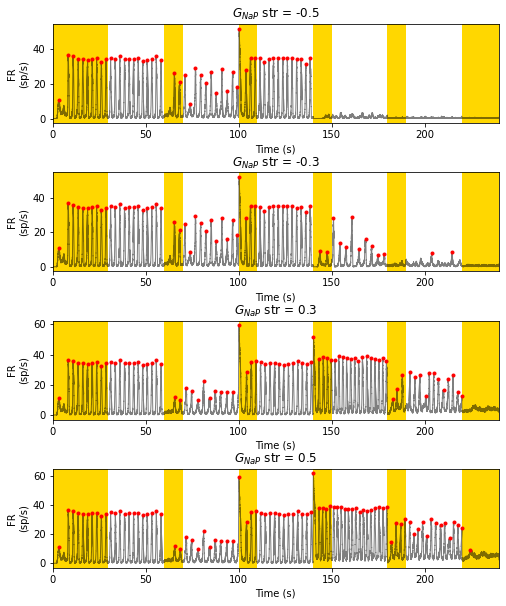

In [6]:
burst_detection(36)

In [7]:
def burst_shapes(run_seed, g_nap_str):
    f = plt.figure(figsize= (18,10))
    f.tight_layout()
    g = f.add_gridspec(3, 1)
    
    # plot example sims w/ burst detection
    # sim w/ positive g_nap_str
    with open(f'pkl_files/seed{run_seed}-str0{int(g_nap_str * 10)}_longer_vars.pkl','rb') as fid1:
        gnap_data = pickle.load(fid1)
    rate = gnap_data['ratemonitor']
    
    binsize = 10 * ms
    smoothed_pop_rate = bup.smooth_saved_rate(rate, binsize)
    burst_stats = bup.pop_burst_stats(rate['t'], smoothed_pop_rate, height = 4, prominence = 6)
    
    # mark burst peaks
    ax0 = f.add_subplot(g[0,0])
    plt.plot(rate['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
    
    plt.ylabel('FR\n(sp/s)')
    plt.xlim(40,50)
    plt.ylim(0,40)
   # plt.plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "red")
    plt.title(r'Control: $G_{NaP}$ str = ' + str(g_nap_str))
    
    # highlighting detected bursts and transient periods
#     for index, row in burst_stats.iterrows():
#         plt.axvspan(row['Onset Times'], row['Offset Times'], edgecolor='y', alpha=0.5, lw=0)
#         plt.axvspan(0, 10, color='r', alpha=0.5, lw=0)

    # mark burst peaks
    ax1 = f.add_subplot(g[1,0])
    plt.plot(rate['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
    
    plt.ylabel('FR\n(sp/s)')
    # plt.plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "red")
    plt.title(r'DAMGO: $G_{NaP}$ str = ' + str(g_nap_str))
    plt.xlim(80,90)
    plt.ylim(0,40)
    plt.subplots_adjust(hspace=0.5)
    
    ax2 = f.add_subplot(g[2,0])
    plt.plot(rate['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('FR\n(sp/s)')
    # plt.plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "red")
    plt.title(r'DAMGO + $G_{NaP}$: $G_{NaP}$ str = ' + str(g_nap_str))
    plt.xlim(200,210)
    plt.ylim(0,40)
    plt.subplots_adjust(hspace=0.5)
    
#     # highlighting detected bursts and transient periods
#     for index, row in burst_stats.iterrows():
#         plt.axvspan(row['Onset Times'], row['Offset Times'], edgecolor='y', alpha=0.5, lw=0)
#         plt.axvspan(40, 50, color='r', alpha=0.5, lw=0)
        
    plt.savefig(f'gnap_mod_figs/seed{run_seed}_gnap_0{g_nap_str*10}_burst_shapes.png')

In [2]:
def overlay_bursts(run_seed, g_nap_str, ylim):
    # plot example sims w/ burst detection
    # sim w/ positive g_nap_str
    if g_nap_str < 0:
        with open(f'gnap_mod_pkls/batch1_pkls/seed{run_seed}-str-0{int(-1*g_nap_str * 10)}_run_vars.pkl','rb') as fid1:
            gnap_data = pickle.load(fid1)
        rate = gnap_data['ratemonitor']
    else:
        with open(f'gnap_mod_pkls/batch1_pkls/seed{run_seed}-str0{int(g_nap_str * 10)}_run_vars.pkl','rb') as fid1:
            gnap_data = pickle.load(fid1)
        rate = gnap_data['ratemonitor']

    width = 100 * ms
    smoothed_pop_rate = bup.smooth_saved_rate(rate, width)
    burst_stats = bup.pop_burst_stats(rate['t'], smoothed_pop_rate, height = 4, prominence = 6)
    
    fig = plt.figure(figsize = (18,6))
    g = fig.add_gridspec(1,3)
    fig.tight_layout()
    ax1 = fig.add_subplot(g[0,0])
    ax2 = fig.add_subplot(g[0,1], sharey = ax1)
    ax3 = fig.add_subplot(g[0,2], sharey = ax1)
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax3.set_xticks([])
    
    for i, burst in burst_stats.iterrows():
        #ind = np.logical_and(rate['t'] >= j['Peak Times']-1, rate['t'] < j['Peak Times']+1)
        if burst['Onset Times'] >= 30 and burst['Offset Times'] <= 60:
            ax1.plot(rate['t'], smoothed_pop_rate, 'b', linewidth=1, alpha=0.5, c = 'k')
            ax1.plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "red", markersize=10)
#             ax1.plot(burst_stats['Onset Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "blue", markersize=10)
#             ax1.plot(burst_stats['Offset Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "green", markersize=10)
            ax1.axvline(x = burst['Peak Times'], linestyle = '--', c = 'k')
            ax1.axvline(x = burst['Onset Times'], linestyle = '--', c = 'gold', alpha = 0.2)
            ax1.axvline(x = burst['Offset Times'], linestyle = '--', c = 'purple', alpha = 0.2)
            ax1.set_xlim(burst['Peak Times']-1.5, burst['Peak Times']+1.5)
            ax1.set_xticks([])
            ax1.set_ylim(0,ylim)
            ax1.set_ylabel('FR\n(Hz/cell)')
#             ax1.set_title('Control Burst Shapes')
            ax1 = ax1.twiny()
            
        if burst['Onset Times'] >= 70. and burst['Offset Times'] <= 100:
            ax2.plot(rate['t'], smoothed_pop_rate, 'b', linewidth=1, alpha=0.5, c = 'k')
            ax2.plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "red", markersize=10)
#             ax2.plot(burst_stats['Onset Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "blue", markersize=10)
#             ax2.plot(burst_stats['Offset Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "green", markersize=10)
            ax2.axvline(x = burst['Peak Times'], linestyle = '--', c = 'k')
            ax2.axvline(x = burst['Onset Times'], linestyle = '--', c = 'gold', alpha = 0.5)
            ax2.axvline(x = burst['Offset Times'], linestyle = '--', c = 'purple', alpha = 0.5)
            ax2.set_xlim(burst['Peak Times']-1.5, burst['Peak Times']+1.5)
            ax2.set_xticks([])
#             ax2.set_xlabel('Peak Time (s)')
#             ax2.set_title('DAMGO Burst Shapes')
            ax2 = ax2.twiny()
    
            
        if burst['Onset Times'] >= 190. and burst['Offset Times'] <= 220:
            ax3.plot(rate['t'], smoothed_pop_rate, 'b', linewidth=1, alpha=0.5, c = 'k')
            ax3.plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "red", markersize=10)
#             ax3.plot(burst_stats['Onset Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "blue", markersize=10)
#             ax3.plot(burst_stats['Offset Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "green", markersize=10)
            ax3.axvline(x = burst['Peak Times'], linestyle = '--', c = 'k')
            ax3.axvline(x = burst['Onset Times'], linestyle = '--', c = 'gold', alpha = 0.5)
            ax3.axvline(x = burst['Offset Times'], linestyle = '--', c = 'purple', alpha = 0.5)
            ax3.set_xlim(burst['Peak Times']-1.5, burst['Peak Times']+1.5)
            ax3.set_xticks([])
#             ax3.set_xlabel('Peak Time (s)')
#             ax3.set_title(r'DAMGO + $G_{NaP}$ Burst Shapes')
            ax3 = ax3.twiny()
    
    ax1.set_xticks([])
    ax1.set_title('Control Burst Shapes')
    ax1.set_xlabel('Burst Peaks')
    ax1.set_ylabel('FR\n(Hz/cell)')
    
    ax2.set_xticks([])
    ax2.set_title('DAMGO Burst Shapes')
    ax2.set_xlabel('Burst Peaks')
    
    
    ax3.set_xticks([])
    ax3.set_title(r'DAMGO + $G_{NaP}$ Burst Shapes')
    ax3.set_xlabel('Burst Peaks')
   
    plt.savefig(f'gnap_mod_figs/seed{run_seed}str{g_nap_str}_overlay.png',dpi=300)

### Loading in the data

In [2]:
df = pd.read_csv('seed1to40_con20_burst_stats.csv')
df[r'$G_{NaP}$ str'] = 1 + df[r'$G_{NaP}$ str']
df[r'$G_{NaP}$ str']
#df = df.loc[df[r'$G_{NaP}$ str'] == 0.5].loc[df['Condition']==r'DAMGO + $G_{NaP}$']['Condition'] = r'DAMGO + $G_{NaP} \times 0.5$' 
#df = df.loc[df[r'$G_{NaP}$ str'] == 0.7].loc[df['Condition']==r'DAMGO + $G_{NaP}$']['Condition'] = r'DAMGO + $G_{NaP} \times 0.7$' 
#df.loc[df[r'$G_{NaP}$ str'] == 0.9].loc[df['Condition']==r'DAMGO + $G_{NaP}$']['Condition'] = r'DAMGO + $G_{NaP} \times 0.9$' 
#df.loc[df[r'$G_{NaP}$ str'] == 1.1].loc[df['Condition']==r'DAMGO + $G_{NaP}$']['Condition'] = r'DAMGO + $G_{NaP} \times 1.1$' 
#df.loc[df[r'$G_{NaP}$ str'] == 1.3].loc[df['Condition']==r'DAMGO + $G_{NaP}$']['Condition'] = r'DAMGO + $G_{NaP} \times 1.3$' 
#df.loc[df[r'$G_{NaP}$ str'] == 1.5].loc[df['Condition']==r'DAMGO + $G_{NaP}$']['Condition'] = r'DAMGO + $G_{NaP} \times 1.5$' 

df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 0.5), 'Condition'] = r'DAMGO + $G_{NaP} \times 0.5$' 
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 0.7), 'Condition'] = r'DAMGO + $G_{NaP} \times 0.7$' 
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 0.9), 'Condition'] = r'DAMGO + $G_{NaP} \times 0.9$' 
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 1.1), 'Condition'] = r'DAMGO + $G_{NaP} \times 1.1$'
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 1.3), 'Condition'] = r'DAMGO + $G_{NaP} \times 1.3$'
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 1.5), 'Condition'] = r'DAMGO + $G_{NaP} \times 1.5$'
df

# df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == -0.5), 'Condition'] = r'DAMGO + $G_{NaP} \times 0.5$' 
# df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == -0.3), 'Condition'] = r'DAMGO + $G_{NaP} \times 0.7$' 
# df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == -0.1), 'Condition'] = r'DAMGO + $G_{NaP} \times 0.9$' 
# df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 0.1), 'Condition'] = r'DAMGO + $G_{NaP} \times 1.1$'
# df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 0.3), 'Condition'] = r'DAMGO + $G_{NaP} \times 1.3$'
# df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 0.5), 'Condition'] = r'DAMGO + $G_{NaP} \times 1.5$'
df


,Unnamed: 0,Peak Samples,Peak Times,Burst Width,Burst Amp,Onset Times,Offset Times,PBI,IBI,Frequency,Period,Peaks,filename,Condition,run_seed,$G_{NaP}$ str
0,0,61892,3.09460,1.428504,1.406625,2.77955,4.20805,1.64590,3.07440,0.325558,3.07165,14.066253,seed1-gnap01_con20_vars.pkl,Transient,1,1.1
1,1,123325,6.16625,0.949848,4.690889,5.85395,6.80380,1.90015,2.85000,0.350637,2.85195,46.908894,seed1-gnap01_con20_vars.pkl,Transient,1,1.1
2,2,180364,9.01820,0.958392,4.847763,8.70395,9.66235,1.91205,2.87045,0.349327,2.86265,48.477628,seed1-gnap01_con20_vars.pkl,Transient,1,1.1
3,3,237617,11.88085,0.980085,4.892651,11.57445,12.55455,1.92410,2.90420,0.345728,2.89245,48.926509,seed1-gnap01_con20_vars.pkl,Transient,1,1.1
4,4,295466,14.77330,0.969869,4.898853,14.47860,15.44850,1.92920,2.89905,0.344679,2.90125,48.988527,seed1-gnap01_con20_vars.pkl,Transient,1,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16006,16006,4242827,212.14135,1.144602,4.239028,211.65260,212.79720,1.39845,2.54305,0.391474,2.55445,42.390276,seed40-gnap03_con20_vars.pkl,DAMGO + $G_{NaP} \times 1.3$,40,1.3
16007,16007,4293916,214.69580,1.150350,4.222496,214.19565,215.34600,1.40090,2.55125,0.394275,2.53630,42.224965,seed40-gnap03_con20_vars.pkl,DAMGO + $G_{NaP} \times 1.3$,40,1.3
16008,16008,4344642,217.23210,1.137558,4.256909,216.74695,217.88450,1.38450,2.52210,0.395202,2.53035,42.569087,seed40-gnap03_con20_vars.pkl,DAMGO + $G_{NaP} \times 1.3$,40,1.3
16009,16009,4395249,219.76245,0.762269,4.223012,219.26900,220.03130,5.05860,5.82085,0.142273,7.02875,42.230123,seed40-gnap03_con20_vars.pkl,DAMGO + $G_{NaP} \times 1.3$,40,1.3


In [94]:
def percent_change_plots(df):
    f = plt.figure(figsize= (6,5))
    f.tight_layout()
    g = f.add_gridspec(2, 1)
    
    control_df = df.loc[df['Condition'] == 'Control']
    damgo_gnap_df = df.loc[df['Condition'] == r'DAMGO + $G_{NaP}$']
    damgo_df= df.loc[df['Condition'] == 'DAMGO']
    
    damgo_gnap_freq = damgo_gnap_df.groupby(r'$G_{NaP}$ str').mean()['Frequency'] 
    control_freq = control_df.groupby(r'$G_{NaP}$ str').mean()['Frequency']
    damgo_freq = damgo_df.groupby(r'$G_{NaP}$ str').mean()['Frequency']
    
    damgo_gnap_freq_sem = damgo_gnap_df.groupby(r'$G_{NaP}$ str').sem()['Frequency'] 
    control_freq_sem = control_df.groupby(r'$G_{NaP}$ str').sem()['Frequency']
    damgo_freq_sem = damgo_df.groupby(r'$G_{NaP}$ str').sem()['Frequency']
    
    freq_percent_changes = (damgo_gnap_freq / control_freq) / (damgo_freq / control_freq)
    freq_sem_percent_changes = (damgo_gnap_freq_sem / control_freq_sem) / (damgo_freq_sem / control_freq_sem)
    
    damgo_gnap_amp = damgo_gnap_df.groupby(r'$G_{NaP}$ str').mean()['Burst Amp'] 
    control_amp = control_df.groupby(r'$G_{NaP}$ str').mean()['Burst Amp']
    damgo_amp = damgo_df.groupby(r'$G_{NaP}$ str').mean()['Burst Amp']
    
    damgo_gnap_amp_sem = damgo_gnap_df.groupby(r'$G_{NaP}$ str').sem()['Burst Amp'] 
    control_amp_sem = control_df.groupby(r'$G_{NaP}$ str').sem()['Burst Amp']
    damgo_amp_sem = damgo_df.groupby(r'$G_{NaP}$ str').sem()['Burst Amp']
    
    amp_percent_changes = (damgo_gnap_amp / control_amp) / (damgo_amp / control_amp)
    amp_sem_percent_changes = (damgo_gnap_amp_sem / control_amp_sem) / (damgo_amp_sem / control_amp_sem)
    
    
    ax0 = f.add_subplot(g[0,0])
    ax0 = freq_percent_changes.plot(kind = 'bar', rot = 0, yerr = freq_sem_percent_changes, color = 'deepskyblue', capsize=3)
    ax0.axhline(y=1, linestyle = '--', color='tab:orange')
    ax0.set_ylabel('Frequency \n% change from control')
    ax0.set_ylim(0,2.9)
    
    ax1 = f.add_subplot(g[1,0], sharex = ax0)
    ax1 = amp_percent_changes.plot(kind = 'bar', rot = 0, yerr = amp_sem_percent_changes, color = 'deepskyblue', capsize=3)
    ax1.axhline(y=1, linestyle = '--',color='tab:orange')
    ax1.set_ylabel('Amplitude \n% change from control')
    ax1.set_ylim(0,2.9)
    
    plt.savefig('gnap_percent_change_plots.png', dpi=300)

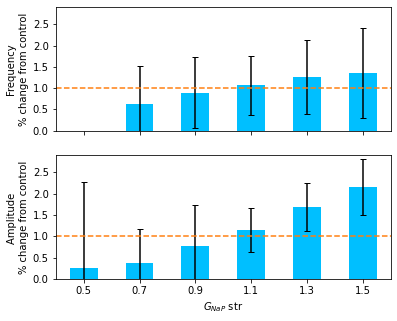

In [7]:
percent_change_plots(df)

In [17]:
control_df = df.loc[df['Condition'] == 'Control']
damgo_gnap_df = df.loc[df['Condition'] == r'DAMGO + $G_{NaP}$']
damgo_df= df.loc[df['Condition'] == 'DAMGO']

damgo_gnap_freq = damgo_gnap_df.groupby(r'$G_{NaP}$ str').mean()['Frequency'] 
control_freq = control_df.groupby(r'$G_{NaP}$ str').mean()['Frequency']
damgo_freq = damgo_df.groupby(r'$G_{NaP}$ str').mean()['Frequency']

damgo_gnap_freq_sem = damgo_gnap_df.groupby(r'$G_{NaP}$ str').sem()['Frequency'] 
control_freq_sem = control_df.groupby(r'$G_{NaP}$ str').sem()['Frequency']
damgo_freq_sem = damgo_df.groupby(r'$G_{NaP}$ str').sem()['Frequency']

freq_percent_changes = (damgo_gnap_freq / control_freq) / (damgo_freq / control_freq)
freq_sem_percent_changes = (damgo_gnap_freq_sem / control_freq_sem) / (damgo_freq_sem / control_freq_sem)

damgo_gnap_freq_sem


$G_{NaP}$ str
-0.5         NaN
-0.3    0.006172
-0.1    0.005763
 0.1    0.003947
 0.3    0.005112
 0.5    0.006155
Name: Frequency, dtype: float64

### View overlay of burst shapes by condition

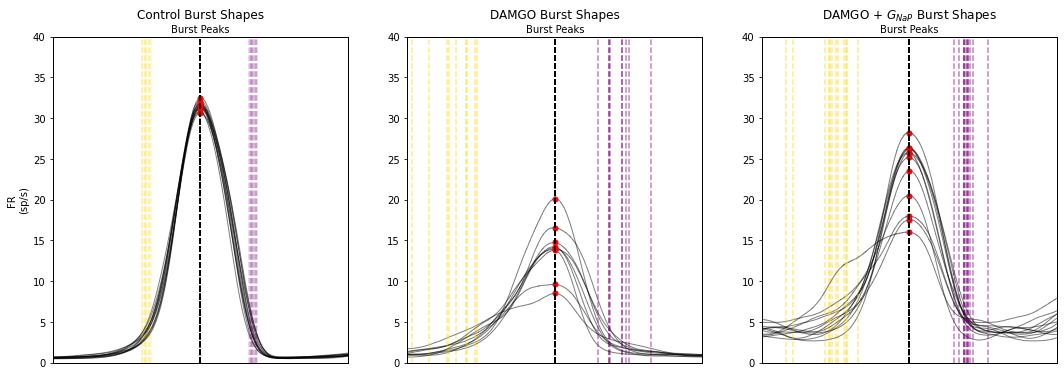

In [5]:
overlay_bursts(36,0.5,40)

### View irregularity plots

In [2]:
df = pd.read_csv('gnap_mod_burst_stats.csv')
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 0.5), 'Condition'] = r'DAMGO + $G_{NaP} \times 1.5$' 
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 0.3), 'Condition'] = r'DAMGO + $G_{NaP} \times 1.3$' 
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == 0.1), 'Condition'] = r'DAMGO + $G_{NaP} \times 1.1$' 
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == -0.1), 'Condition'] = r'DAMGO + $G_{NaP} \times 0.9$'
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == -0.3), 'Condition'] = r'DAMGO + $G_{NaP} \times 0.7$'
df.loc[(df['Condition'] == r'DAMGO + $G_{NaP}$') & (df[r'$G_{NaP}$ str'] == -0.5), 'Condition'] = r'DAMGO + $G_{NaP} \times 0.5$'


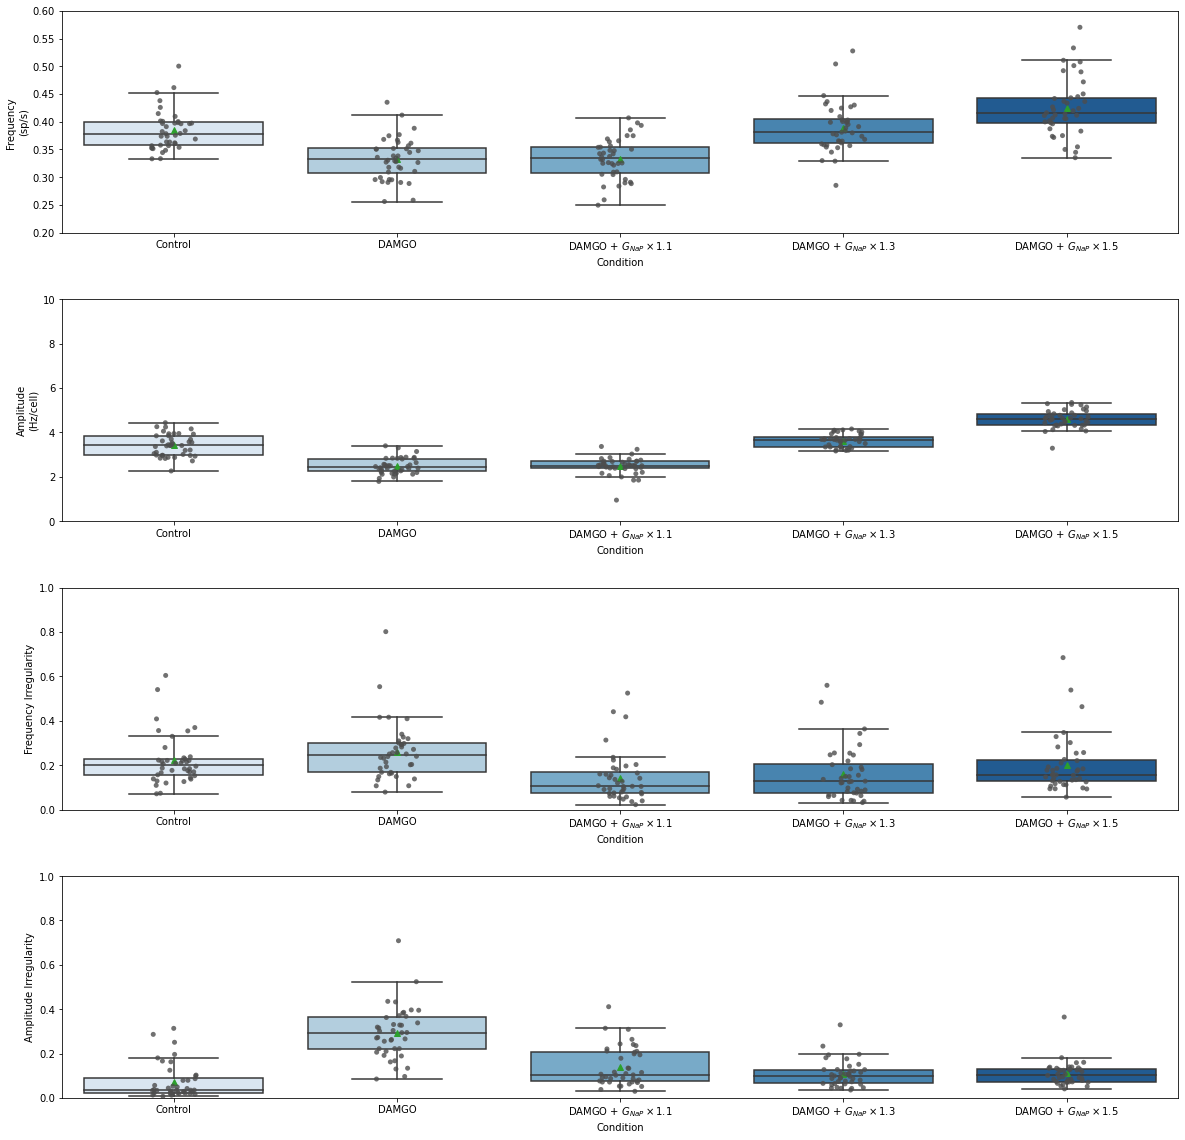

In [3]:
f = plt.figure(figsize=(20,20))
f.tight_layout()
plt.subplots_adjust(hspace=0.3) 
# f = plt.figure(figsize= (5,5))
# f.tight_layout()
g = f.add_gridspec(4, 1)
    
# grab average frequency, amplitude, and width per condition
gnap_df = df
gnap_df = gnap_df[gnap_df['Condition'] != 'Block']
gnap_df = gnap_df[gnap_df['Condition'] != 'Transient']
gnap_df = gnap_df[gnap_df['Condition'] != 'Wash Block']
gnap_df = gnap_df[gnap_df['Condition'] != 'Control Block']
gnap_df = gnap_df[gnap_df['Condition'] != 'DAMGO Block']
gnap_df = gnap_df[gnap_df['Condition'] != r'$G_{NaP}$ Block']
gnap_df = gnap_df[gnap_df['Condition'] != r'DAMGO + $G_{NaP}$ Block']
gnap_df = gnap_df[gnap_df['Condition'] != r'$G_{NaP}$']
gnap_df = gnap_df[gnap_df['Condition'] != 'Wash']
gnap_df = gnap_df[gnap_df['Condition'] != r'DAMGO + $G_{NaP} \times 0.9$']
gnap_df = gnap_df[gnap_df['Condition'] != r'DAMGO + $G_{NaP} \times 0.7$']
gnap_df = gnap_df[gnap_df['Condition'] != r'DAMGO + $G_{NaP} \times 0.5$']

avg_freq_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Frequency']
avg_freq_df = avg_freq_by_seed.to_frame()

avg_amp_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Burst Amp']
avg_amp_df = avg_amp_by_seed.to_frame()

avg_width_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Burst Width']
avg_width_df = avg_width_by_seed.to_frame()

avg_period_by_seed = gnap_df.groupby(['run_seed', 'Condition']).mean()['Period']
avg_period_df = avg_period_by_seed.to_frame()

avg_freq_df['Condition'] = avg_freq_df['Frequency'].keys().get_level_values(1)
avg_freq_df

avg_amp_df['Condition'] = avg_amp_df['Burst Amp'].keys().get_level_values(1)
avg_amp_df


ax1 = f.add_subplot(g[0,0])
ax1 = sns.boxplot(data = avg_freq_df, x='Condition', y='Frequency', showmeans = True, showfliers=False, palette="Blues",)#order=['Control', 'DAMGO', r'DAMGO + $G_{Leak} \times 0.9$', r'DAMGO + $G_{Leak} \times 0.7$', r'DAMGO + $G_{Leak} \times 0.5$'])
ax1 = sns.stripplot(data = avg_freq_df, alpha=0.8, color=".3", x='Condition', y='Frequency')#, order=['Control', 'DAMGO', r'DAMGO + $G_{Leak} \times 0.9$', r'DAMGO + $G_{Leak} \times 0.7$', r'DAMGO + $G_{Leak} \times 0.5$'])
#ax1.set_xlabel('')
#ax1.set_title(r'$G_{Leak}$ str = ' + f'{1.3}')
ax1.set_ylabel('Frequency \n(sp/s)')
ax1.set_ylim(0.2,0.6)

ax2 = f.add_subplot(g[1,0])
ax2 = sns.boxplot(data = avg_amp_df, x='Condition', y='Burst Amp', showmeans = True, showfliers=False, palette="Blues",)#order=['Control', 'DAMGO', r'DAMGO + $G_{Leak} \times 0.9$', r'DAMGO + $G_{Leak} \times 0.7$', r'DAMGO + $G_{Leak} \times 0.5$'])
ax2 = sns.stripplot(data = avg_amp_df,alpha=0.8, color=".3",x='Condition', y='Burst Amp', )#order=['Control', 'DAMGO', r'DAMGO + $G_{Leak} \times 0.9$', r'DAMGO + $G_{Leak} \times 0.7$', r'DAMGO + $G_{Leak} \times 0.5$'])
# ax2.set_xlabel('')
ax2.set_ylabel('Amplitude\n(Hz/cell)')
# ax2.set_yticks(np.arange(0,6,1))
# ax2.set_title('')
ax2.set_ylim(0,10)

amps = gnap_df.groupby(['run_seed','Condition'])['Burst Amp'].agg(bup.irregularity)
freqs = gnap_df.groupby(['run_seed','Condition'])['Frequency'].agg(bup.irregularity)
amps_df = amps.to_frame()
freqs_df = freqs.to_frame()

amps_df['Condition'] = amps_df['Burst Amp'].keys().get_level_values(1)
freqs_df['Condition'] = freqs_df['Frequency'].keys().get_level_values(1)

ax3 = f.add_subplot(g[2,0])
ax3 = sns.boxplot(data = freqs_df, x='Condition', y='Frequency', showmeans = True, showfliers=False, palette="Blues",)#order=['Control', 'DAMGO', r'DAMGO + $G_{Leak} \times 0.9$', r'DAMGO + $G_{Leak} \times 0.7$', r'DAMGO + $G_{Leak} \times 0.5$'])
ax3 = sns.stripplot(data = freqs_df, alpha=0.8, color=".3",x='Condition', y='Frequency', )#order=['Control', 'DAMGO', r'DAMGO + $G_{Leak} \times 0.9$', r'DAMGO + $G_{Leak} \times 0.7$', r'DAMGO + $G_{Leak} \times 0.5$'])
ax3.set_ylabel('Frequency Irregularity')
# ax3.set_ylim(0,)
# ax3.set_title('')
ax3.set_ylim(0,1)

ax4 = f.add_subplot(g[3,0])
ax4 = sns.boxplot(data = amps_df, x='Condition', y='Burst Amp', showmeans = True, showfliers=False, palette="Blues",)#order=['Control', 'DAMGO', r'DAMGO + $G_{Leak} \times 0.9$', r'DAMGO + $G_{Leak} \times 0.7$', r'DAMGO + $G_{Leak} \times 0.5$'])
ax4 = sns.stripplot(data = amps_df, alpha=0.8, color=".3", x='Condition', y='Burst Amp',)#order=['Control', 'DAMGO', r'DAMGO + $G_{Leak} \times 0.9$', r'DAMGO + $G_{Leak} \times 0.7$', r'DAMGO + $G_{Leak} \times 0.5$'])
ax4.set_ylabel('Amplitude Irregularity')
ax4.set_ylim(0,1)

plt.savefig('gnap_sparse_boxplots.png', dpi=300)
plt.savefig('gnap_sparse_boxplots.pdf')

In [17]:
avg_freq_df.to_csv('gnap_mod_avg_freqs.csv')
avg_amp_df.to_csv('gnap_mod_avg_amps.csv')

KeyError: "['Frequency'] not in index"

In [26]:
avg_freq_df.reset_index()

ValueError: cannot insert Condition, already exists

In [20]:
freqs_df = freqs_df.rename(columns={'Frequency': 'Frequency Irregularity'})
freqs_df.to_csv('gnap_mod_freq_irreg.csv')
amps_df = amps_df.rename(columns={'Burst Amp': 'Amplitude Irregularity'})
amps_df.to_csv('gnap_mod_amp_irreg.csv')

### View percent changes in frequency, amplitude, and width

In [ ]:
percent_change_plots(df)

### Create heatmap of response variable averages based on condition and g_nap_str

In [ ]:
# THIS IS A WORK IN PROGRESS
plt.figure()
heatmap_df = df.pivot_table(index = 'g_nap_str', columns = 'Condition', values = 'Frequency')
ax = sns.heatmap(heatmap_df, cmap = 'rocket', mask = heatmap_df.isnull(), vmin = 0, vmax = 0.7, cbar_kws={'label': 'Frequency'})
ax.invert_yaxis()
plt.yticks(rotation=0)
plt.show()
heatmap_df